In [1]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


In [5]:
# Cell 2: Load and inspect datasets
#fraud_data = pd.read_csv('processed_fraud_data_test.csv')
fraud_data =pd.read_csv(r'C:/Users/Daniel.Temesgen/Desktop/KIAM/week89/Fraud_Data.csv')
creditcard_data  = pd.read_csv(r'C:/Users/Daniel.Temesgen/Desktop/KIAM/creditcard.csv')

print(f'Fraud Data shape: {fraud_data.shape}')
print(f'Credit Card Data shape: {creditcard_data.shape}\n')

print("Fraud Data sample:")
display(fraud_data.head())
print("\nCredit Card Data sample:")
display(creditcard_data.head())

Fraud Data shape: (151112, 11)
Credit Card Data shape: (284807, 31)

Fraud Data sample:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0



Credit Card Data sample:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# Cell 3: Preprocessing functions
def preprocess_fraud_data(df):
    # Handle missing values
    df = df.dropna(subset=['user_id', 'purchase_time', 'purchase_value'])
    for col in ['source', 'browser', 'sex']:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0])
    df['age'] = df['age'].fillna(df['age'].median())

    # Remove duplicates
    df = df.drop_duplicates()

    # Convert data types
    df['signup_time'] = pd.to_datetime(df['signup_time'])
    df['purchase_time'] = pd.to_datetime(df['purchase_time'])
    df['user_id'] = df['user_id'].astype(int)
    df['purchase_value'] = df['purchase_value'].astype(float)
    df['age'] = df['age'].astype(int)

    # Feature engineering
    user_purchase_counts = df.groupby('user_id').size().reset_index(name='transaction_frequency')
    df = df.merge(user_purchase_counts, on='user_id')
    df['hour_of_day'] = df['purchase_time'].dt.hour
    df['day_of_week'] = df['purchase_time'].dt.dayofweek
    df['time_since_signup'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds() / 3600

    # Separate features and target
    X = df.drop(['class', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'], axis=1)
    y = df['class']

    return X, y

def preprocess_creditcard_data(df):
    # Handle missing values
    df = df.dropna(subset=['Amount', 'Class'])
    df = df.drop_duplicates()
    
    # Separate features and target
    X = df.drop(['Class'], axis=1)
    y = df['Class']
    
    return X, y

In [7]:
# Cell 4: Apply preprocessing
X_fraud, y_fraud = preprocess_fraud_data(fraud_data)
X_creditcard, y_creditcard = preprocess_creditcard_data(creditcard_data)

print("Fraud Data features after preprocessing:")
display(X_fraud.head())
print("\nCredit Card Data features after preprocessing:")
display(X_creditcard.head())

Fraud Data features after preprocessing:


,purchase_value,source,browser,sex,age,transaction_frequency,hour_of_day,day_of_week,time_since_signup
0,34.0,SEO,Chrome,M,39,1,2,5,1251.856111
1,16.0,Ads,Chrome,F,53,1,1,0,4.984444
2,15.0,SEO,Opera,M,53,1,18,3,0.000278
3,44.0,SEO,Safari,M,41,1,13,0,136.690278
4,39.0,Ads,Safari,M,45,1,18,2,1211.516944



Credit Card Data features after preprocessing:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [9]:
# Cell 5: Feature encoding and scaling (updated)
def encode_and_scale(X, categorical_cols=None):
    if categorical_cols:
        # One-hot encoding
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Changed sparse to sparse_output
        X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
        X_encoded.columns = encoder.get_feature_names_out(categorical_cols)
        X = X.drop(categorical_cols, axis=1).reset_index(drop=True)
        X = pd.concat([X, X_encoded], axis=1)
    else:
        encoder = None
    
    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, scaler, encoder

# Fraud Data
categorical_cols = ['source', 'browser', 'sex']
X_fraud_scaled, fraud_scaler, fraud_encoder = encode_and_scale(X_fraud, categorical_cols)

# Credit Card Data (no categorical features)
X_creditcard_scaled, creditcard_scaler, _ = encode_and_scale(X_creditcard)

print("Feature scaling completed!")

Feature scaling completed!


In [10]:
# Cell 6: Train-test split and class imbalance handling
# Fraud Data
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud_scaled, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

# Credit Card Data
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(
    X_creditcard_scaled, y_creditcard, test_size=0.2, random_state=42, stratify=y_creditcard
)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)

print("Fraud Data class distribution before SMOTE:")
print(pd.Series(y_fraud_train).value_counts())
X_fraud_train_res, y_fraud_train_res = smote.fit_resample(X_fraud_train, y_fraud_train)
print("\nAfter SMOTE:")
print(pd.Series(y_fraud_train_res).value_counts())

print("\nCredit Card Data class distribution before SMOTE:")
print(pd.Series(y_credit_train).value_counts())
X_credit_train_res, y_credit_train_res = smote.fit_resample(X_credit_train, y_credit_train)
print("\nAfter SMOTE:")
print(pd.Series(y_credit_train_res).value_counts())

Fraud Data class distribution before SMOTE:
class
0    109568
1     11321
Name: count, dtype: int64

After SMOTE:
class
0    109568
1    109568
Name: count, dtype: int64

Credit Card Data class distribution before SMOTE:
Class
0    226602
1       378
Name: count, dtype: int64

After SMOTE:
Class
0    226602
1    226602
Name: count, dtype: int64


=== Fraud Data Evaluation ===

Evaluating Logistic Regression...


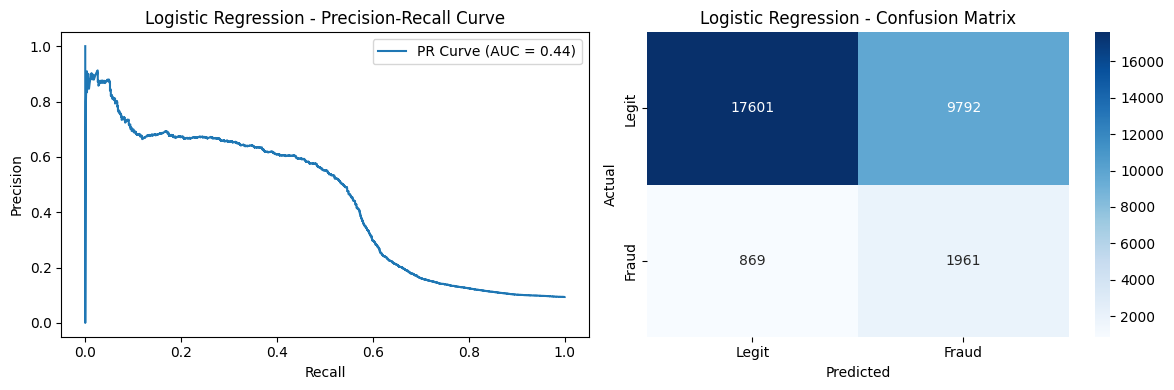


Evaluating Random Forest...


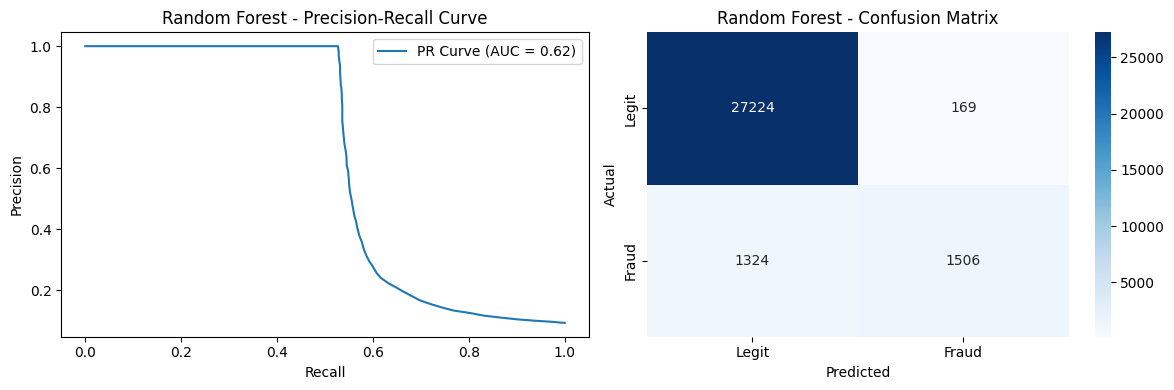


=== Credit Card Data Evaluation ===

Evaluating Logistic Regression...


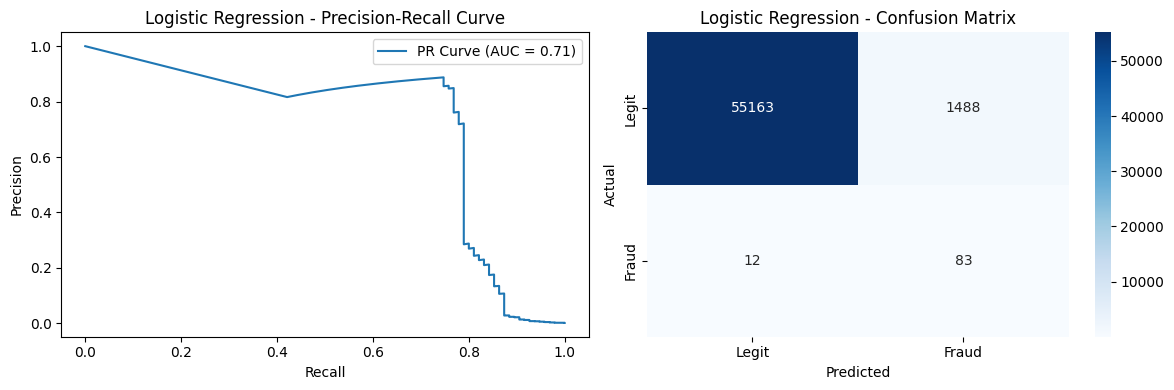


Evaluating Random Forest...


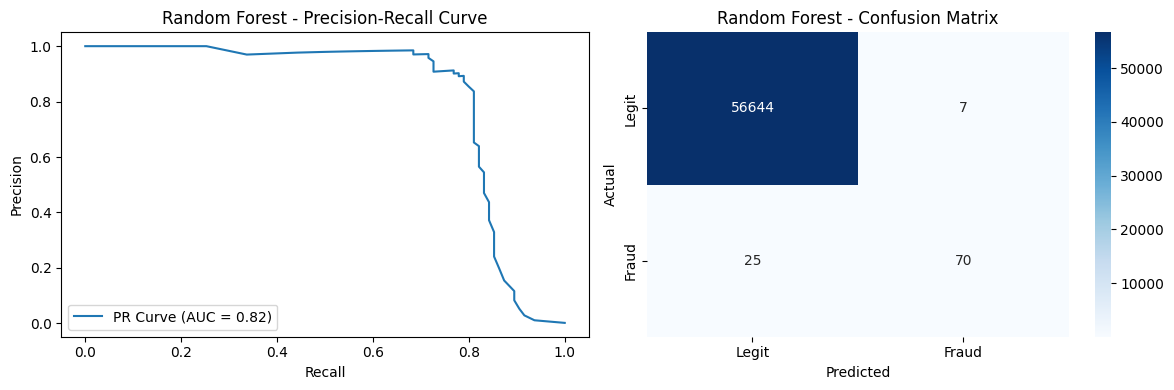

In [11]:
# Cell 7: Model training and evaluation
def train_evaluate_model(X_train, y_train, X_test, y_test, model, model_name):
    # Train model
    model.fit(X_train, y_train)
    
    # Predict probabilities and classes
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legit', 'Fraud'],
                yticklabels=['Legit', 'Fraud'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model_name,
        'pr_auc': pr_auc,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Evaluate on Fraud Data
print("=== Fraud Data Evaluation ===")
fraud_results = []
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    result = train_evaluate_model(
        X_fraud_train_res, y_fraud_train_res,
        X_fraud_test, y_fraud_test,
        model, name
    )
    fraud_results.append(result)

# Evaluate on Credit Card Data
print("\n=== Credit Card Data Evaluation ===")
credit_results = []
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    result = train_evaluate_model(
        X_credit_train_res, y_credit_train_res,
        X_credit_test, y_credit_test,
        model, name
    )
    credit_results.append(result)


=== Fraud Data Results Summary ===


,model,pr_auc,f1_score
0,Logistic Regression,0.440081,0.268943
1,Random Forest,0.620154,0.668590


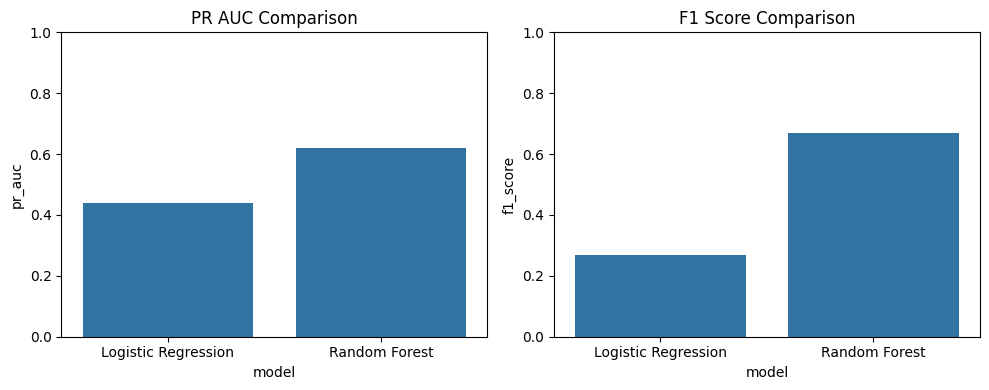


=== Credit Card Data Results Summary ===


,model,pr_auc,f1_score
0,Logistic Regression,0.714663,0.099640
1,Random Forest,0.821569,0.813953


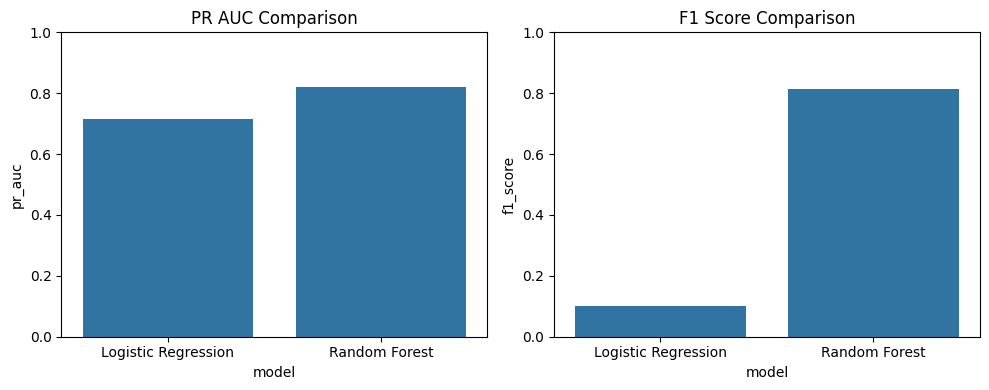


Model training and evaluation completed!


In [12]:
# Cell 8: Results comparison and conclusion
def display_results_summary(results, dataset_name):
    print(f"\n=== {dataset_name} Results Summary ===")
    results_df = pd.DataFrame(results)
    display(results_df[['model', 'pr_auc', 'f1_score']])
    
    # Plot comparison
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.barplot(x='model', y='pr_auc', data=results_df)
    plt.title('PR AUC Comparison')
    plt.ylim(0, 1)
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='model', y='f1_score', data=results_df)
    plt.title('F1 Score Comparison')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

display_results_summary(fraud_results, "Fraud Data")
display_results_summary(credit_results, "Credit Card Data")

print("\nModel training and evaluation completed!")